human


NameError: name 'species' is not defined

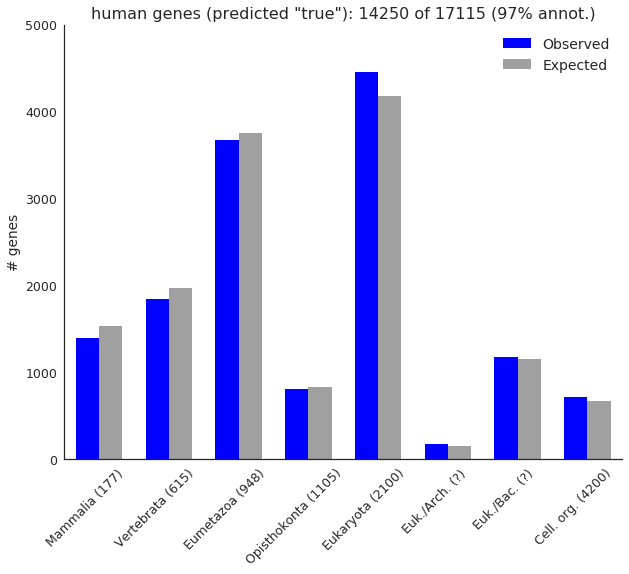

In [3]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import accuracy_score

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

gene_age_files = {'human': os.path.join(fhgfs_base, 'refdata/geneage/norm/human_agefeat.h5'),
                  'mouse': os.path.join(fhgfs_base, 'refdata/geneage/norm/mouse_agefeat.h5')}

gene_model_files = {'human': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/hsa_hg19_gencode_v19.body.h5'),
                    'mouse': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/mmu_mm9_gencode_vM1.body.h5')}

run_exec_gene_ages = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

gene_ages = [('Eumetazoa', 948), ('Eukaryota', 2100),
             ('Vertebrata', 615), ('Opisthokonta', 1105),
             ('Mammalia', 177), ('Euk./Bac.', 3500),
             ('Euk./Arch.', 3000), ('Cell. org.', 4200)]

age_labels = {'Eumetazoa': 948, 'Eukaryota': 2100,
              'Vertebrata': 615, 'Opisthokonta': 1105,
              'Mammalia': 177, 'Euk./Bac.': '?',
              'Euk./Arch.': '?', 'Cell. org.': 4200}

group_labels = {'ftage_bin_eumeta': 'Eumetazoa', 'ftage_bin_euk': 'Eukaryota',
                'ftage_bin_vert': 'Vertebrata', 'ftage_bin_opist': 'Opisthokonta',
                'ftage_bin_mamm': 'Mammalia', 'ftage_bin_eukbac': 'Euk./Bac.',
                'ftage_bin_eukarch': 'Euk./Arch.', 'ftage_bin_cellorg': 'Cell. org.'}

def exec_gene_ages():
    
    for spec, fp in gene_age_files.items():
        print(spec)
        with pd.HDFStore(fp, 'r') as hdf:
            load_key = [k for k in hdf.keys() if k.endswith('/final')]
            load_key = load_key[0]
            age_data = hdf[load_key]
            to_drop = [c for c in age_data.columns if c.startswith('ftconf') or c.startswith('ftage_abs')]
            age_data.drop(to_drop, inplace=True, axis=1)
        gene_file = gene_model_files[spec]
        total_genes = 0
        with pd.HDFStore(gene_file, 'r') as hdf:
            for k in hdf.keys():
                if k != '/metadata':
                    subset = hdf[k]
                    total_genes += subset.shape[0]
        
        spec_color = plot_colors['species'][spec]['rgb']
        annot_genes = age_data.shape[0]
        pct_annot = int(np.round(annot_genes / total_genes, 2) * 100)
        
        count_bg = col.Counter()
        for c in age_data.columns:
            try:
                group = group_labels[c]
                count_bg[group] = np.int16(age_data[c].sum())
            except KeyError:
                continue
    
        for group in ['true', 'false']:
            if group == 'true':
                sub_group = age_data.loc[age_data['target'] > 0.5, :].copy()
                sub_total = sub_group.shape[0]
                bg_factor = sub_total / annot_genes
            else:
                sub_group = age_data.loc[age_data['target'] <= 0.5, :].copy()
                sub_total = sub_group.shape[0]
                bg_factor = sub_total / annot_genes
            
            count_fg = col.Counter()
            for c in sub_group.columns:
                try:
                    grp = group_labels[c]
                    count_fg[grp] = np.int16(sub_group[c].sum())
                except KeyError:
                    continue
            
            title = '{} genes (predicted "{}"): {} of {} ({}% annot.)'.format(spec, group, sub_total,
                                                                       annot_genes, pct_annot)
            fig, exart = plot_count_bars(count_fg, spec_color, count_bg, bg_factor, title)
            if save_figures:
                outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}_gene-age_{}.svg'.format(species, group))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True
            
            
def plot_count_bars(fg_group, fg_color, bg_group, bg_factor, title):
    """
    """
    sort_order = sorted(gene_ages, key=lambda t: t[1])
    
    fg_means = np.array([fg_group[l] for l, t in sort_order], dtype=np.int32)
    bg_means = np.array([bg_group[l] for l, t in sort_order], dtype=np.float32)
    bg_means *= bg_factor
    bg_means.round(0)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, 6)
    
    ht_limit = max(fg_means.max(), bg_means.max())
    ht_limit = np.ceil(ht_limit / 1000) * 1000
        
    ax.set_ylim(0, ht_limit)
    
    
    bar_width = 0.25
    x_fg = np.arange(0.25, len(sort_order), 0.75)[:fg_means.size]
    x_bg = np.arange(0.5, len(sort_order), 0.75)[:bg_means.size]
    x_ticks = (x_fg + x_bg) / 2.
    x_ticks -= 0.15
    
    x_labels = []
    for grp, dist in sort_order:
        mya = str(age_labels[grp])
        x_labels.append('{} ({})'.format(grp, mya))
    x_ticks = x_ticks[:len(x_labels)]
        
    ax.bar(x_fg[:fg_means.size], fg_means, color=fg_color, width=bar_width, label='Observed')
    ax.bar(x_bg[:bg_means.size], bg_means, color='grey', alpha=0.75, width=bar_width, label='Expected')
    
    ax.legend(fontsize=14)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45)
    
    ax.set_ylabel('# genes')
    ax.set_title(title, fontsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, []
   
    
if run_exec_gene_ages:
    execd = exec_gene_ages()
    print('Gene age plot created')
